In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
import reboundx
import pandas as pd
from celmech.poincare import Poincare
import scipy.optimize as opt
%matplotlib inline

In [ ]:
def sim(alpha, mass, ecc, pom, scale):
    alpha12, alpha23 = alpha
    alpha13=alpha12*alpha23
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    m1, m2, m3 = mass
    m_tot = m1+m2+m3
    ecc1, ecc2, ecc3 = ecc
    pomega1, pomega2, pomega3 = pom
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=m1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=m2, P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=m3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/12
    sim.collision = "direct"
    
    Nout=200
    S2, S3, S2_ref, S3_ref, S2_c, S3_c, S2_d, S3_d = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout),np.zeros(Nout), np.zeros(Nout),np.zeros(Nout), np.zeros(Nout)
    times = np.linspace(0,scale,Nout)
    
    r = (1-alpha12)/(1-alpha13)
    C = (2*r-1)/((m1*m2/m_tot-m3)*r**2 + (m2*m3/m_tot-m1)*(1-r)**2 + (m1+m3)**2/m_tot*r**2*(1-r)**2)*m_tot
    w2 = 2*m2/(m1+m3) * (m1/(np.pi*(1-alpha23)**2) + m3/(np.pi*(1-alpha12)**2)) + 2*(m1+m3)/(np.pi*(1-alpha13)**2)
    w3 = 2*m_tot/(m1+m3) * (m1/(np.pi*(1-alpha12)**2) + m3/(np.pi*(1-alpha23)**2))
    k = np.sqrt(m1*m2*m3*m_tot)/(m1+m3) * (2/(np.pi*(1-alpha23)**2) - 2/(np.pi*(1-alpha12)**2))
    phi = 1/2*np.arctan2(2*k, w2-w3)
    
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
            info_1 = sim.particles[1].calculate_orbit(primary=sim.particles[0])
            info_2 = sim.particles[2].calculate_orbit(primary=sim.particles[0])
            info_3 = sim.particles[3].calculate_orbit(primary=sim.particles[0])
            p1, p2, p3, e1, e2, e3 = info_1.pomega, info_2.pomega, info_3.pomega, info_1.e, info_2.e, info_3.e
            e1_x, e1_y = e1*np.cos(p1), e1*np.sin(p1)
            e2_x, e2_y = e2*np.cos(p2), e2*np.sin(p2)
            e3_x, e3_y = e3*np.cos(p3), e3*np.sin(p3)
            
            e13_x = e3_x-e1_x
            e13_y = e3_y-e1_y
            eminus_x = (m3*(e3_x-e2_x)-m1*(e2_x-e1_x))/m_tot
            eminus_y = (m3*(e3_y-e2_y)-m1*(e2_y-e1_y))/m_tot
            S2[i] = np.sqrt(e13_x**2 + e13_y**2)*m_tot/np.sqrt(m2*(m1+m3))
            S3[i] = np.sqrt(eminus_x**2 + eminus_y**2)*np.sqrt(m_tot**3/(m1*m3*(m1+m3)))
            
            S2_ref_x = np.cos(phi)*e13_x*m_tot/np.sqrt(m2*(m1+m3)) + np.sin(phi)*eminus_x*np.sqrt(m_tot**3/(m1*m3*(m1+m3)))
            S2_ref_y = np.cos(phi)*e13_y*m_tot/np.sqrt(m2*(m1+m3)) + np.sin(phi)*eminus_y*np.sqrt(m_tot**3/(m1*m3*(m1+m3)))
            S3_ref_x = -np.sin(phi)*e13_x*m_tot/np.sqrt(m2*(m1+m3)) + np.cos(phi)*eminus_x*np.sqrt(m_tot**3/(m1*m3*(m1+m3)))
            S3_ref_y = -np.sin(phi)*e13_y*m_tot/np.sqrt(m2*(m1+m3)) + np.cos(phi)*eminus_y*np.sqrt(m_tot**3/(m1*m3*(m1+m3)))
            
            S2_ref[i] = np.sqrt(S2_ref_x**2+S2_ref_y**2)
            S3_ref[i] = np.sqrt(S3_ref_x**2+S3_ref_y**2)
            
            S2_c_x = e13_x + m2/m_tot*C*eminus_x
            S2_c_y = e13_y + m2/m_tot*C*eminus_y
            S3_c_x = -m1*m3/m_tot**2*C*e13_x + eminus_x
            S3_c_y = -m1*m3/m_tot**2*C*e13_y + eminus_y
            
            S2_c[i] = np.sqrt(S2_c_x**2+S2_c_y**2) * m_tot/np.sqrt(m2*(m1+m3))
            S3_c[i] = np.sqrt(S3_c_x**2+S3_c_y**2) * np.sqrt(m_tot**3/(m1*m3*(m1+m3)))
            
            delta = r-1/2
            S2_d_x = e13_x - 32*delta/3*m2*m_tot/(m1+m3)**2*eminus_x
            S2_d_y = e13_y - 32*delta/3*m2*m_tot/(m1+m3)**2*eminus_y
            S3_d_x = 32*delta/3*m1*m3/(m1+m3)**2*e13_x + eminus_x
            S3_d_y = 32*delta/3*m1*m3/(m1+m3)**2*e13_y + eminus_y
            S2_d[i] = np.sqrt(S2_d_x**2+S2_d_y**2) * m_tot/np.sqrt(m2*(m1+m3))
            S3_d[i] = np.sqrt(S3_d_x**2+S3_d_y**2) * np.sqrt(m_tot**3/(m1*m3*(m1+m3)))
                       
        except rebound.Collision:
            break
            
    return times, S2, S3, S2_ref, S3_ref, S2_c, S3_c, S2_d, S3_d
#     return times, ecc1, ecc2, ecc3, ecom, e13, eminus, S2, S3

In [12]:
alpha = 0.9, 0.91
mass = 2e-7,1e-7,1e-7
ecc = 0.02, 0.02, 0.02
pomega = 0, 0, np.pi/3
times, S2, S3, S2_ref, S3_ref, S2_c, S3_c, S2_d, S3_d = sim(alpha, mass, ecc, pomega, 1e6)
# times, ecc1, ecc2, ecc3, ecom, e13, eminus, S2, S3 = sim(alpha, mass, ecc, pomega, 1e6)

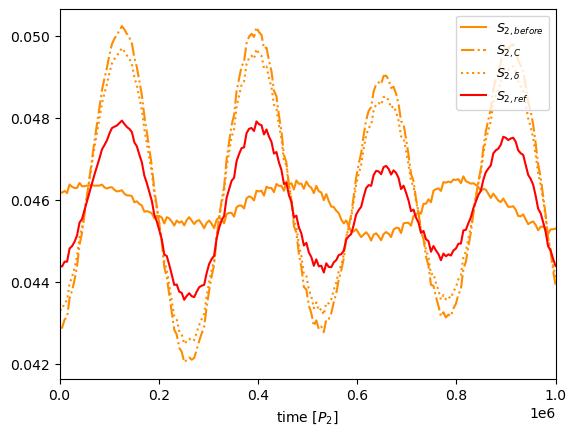

In [13]:
f, ax = plt.subplots()
# ax.plot(times, ecc1, color='dimgray',linestyle='--', label='$e_1$')
# ax.plot(times, ecc2, color='dimgray',linestyle='-.', label='$e_2$')
# ax.plot(times, ecc3, color='dimgray',linestyle=':', label='$e_3$')
# ax.plot(times, ecom, color='mediumpurple', label='$e_{com}$')
ax.plot(times, S2, color='darkorange', linestyle='-', label='$S_{2,before}$')
ax.plot(times, S2_c, color='darkorange', linestyle='-.', label='$S_{2,C}$')
ax.plot(times, S2_d, color='darkorange', linestyle=':', label='$S_{2,\delta}$')
ax.plot(times, S2_ref, color='red', linestyle='-', label='$S_{2,ref}$')
ax.set_xlabel("time [$P_2$]")
ax.set_xlim(0,1e6)
ax.legend(ncols=1, loc="upper right", fontsize=9)

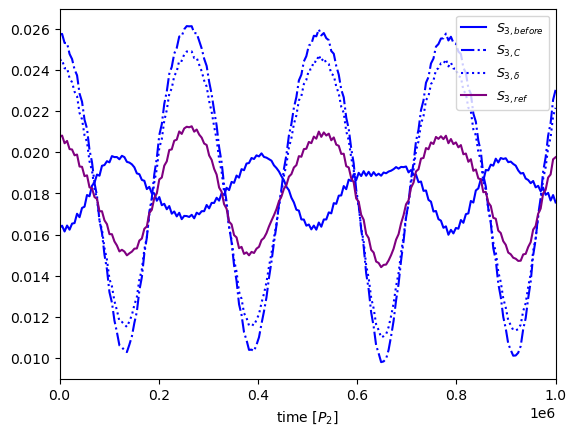

In [14]:
f, ax = plt.subplots()
ax.plot(times, S3, color='blue', linestyle='-', label='$S_{3,before}$')
ax.plot(times, S3_c, color='blue', linestyle='-.', label='$S_{3,C}$')
ax.plot(times, S3_d, color='blue', linestyle=':', label='$S_{3,\delta}$')
ax.plot(times, S3_ref, color='purple', linestyle='-', label='$S_{3,ref}$')
ax.set_xlabel("time [$P_2$]")
ax.set_xlim(0,1e6)
ax.legend(ncols=1, loc="upper right", fontsize=9)

In [25]:
alpha = 0.95, 0.96
mass = 1e-8,1e-8,1e-8
ecc = 0.01, 0.01, 0.01
pomega = 0, 0, np.pi/3
times, S2, S3, S2_ref, S3_ref, S2_c, S3_c, S2_d, S3_d = sim(alpha, mass, ecc, pomega, 5e6)

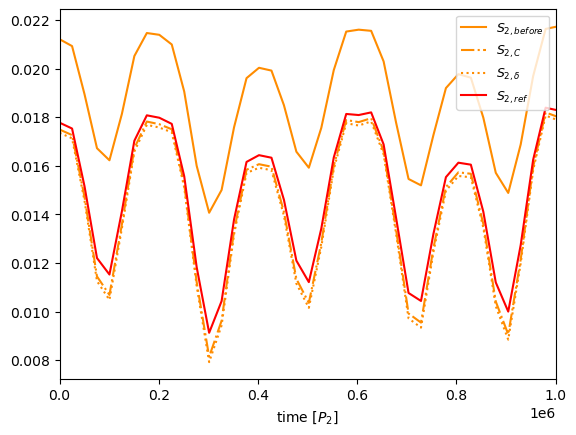

In [26]:
f, ax = plt.subplots()
# ax.plot(times, ecc1, color='dimgray',linestyle='--', label='$e_1$')
# ax.plot(times, ecc2, color='dimgray',linestyle='-.', label='$e_2$')
# ax.plot(times, ecc3, color='dimgray',linestyle=':', label='$e_3$')
# ax.plot(times, ecom, color='mediumpurple', label='$e_{com}$')
ax.plot(times, S2, color='darkorange', linestyle='-', label='$S_{2,before}$')
ax.plot(times, S2_c, color='darkorange', linestyle='-.', label='$S_{2,C}$')
ax.plot(times, S2_d, color='darkorange', linestyle=':', label='$S_{2,\delta}$')
ax.plot(times, S2_ref, color='red', linestyle='-', label='$S_{2,ref}$')
ax.set_xlabel("time [$P_2$]")
ax.set_xlim(0,1e6)
ax.legend(ncols=1, loc="upper right", fontsize=9)

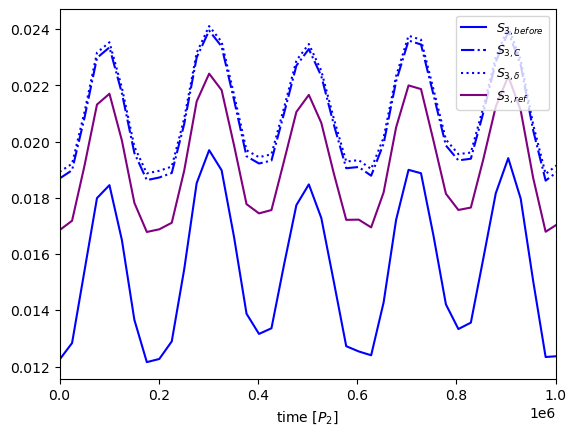

In [28]:
f, ax = plt.subplots()
ax.plot(times, S3, color='blue', linestyle='-', label='$S_{3,before}$')
ax.plot(times, S3_c, color='blue', linestyle='-.', label='$S_{3,C}$')
ax.plot(times, S3_d, color='blue', linestyle=':', label='$S_{3,\delta}$')
ax.plot(times, S3_ref, color='purple', linestyle='-', label='$S_{3,ref}$')
ax.set_xlabel("time [$P_2$]")
ax.set_xlim(0,1e6)
ax.legend(ncols=1, loc="upper right", fontsize=9)

In [ ]:
def sim(alpha, mass, ecc, pom, scale):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu3 = mass
    ecc1, ecc2, ecc3 = ecc
    pomega1, pomega2, pomega3 = pom
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    Nout=400
    e12, e23 = np.zeros(Nout), np.zeros(Nout)
    times = np.linspace(0,scale,Nout)
    
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
            info_1 = sim.particles[1].calculate_orbit(primary=sim.particles[0])
            info_2 = sim.particles[2].calculate_orbit(primary=sim.particles[0])
            info_3 = sim.particles[3].calculate_orbit(primary=sim.particles[0])
            p1, p2, p3, e1, e2, e3 = info_1.pomega, info_2.pomega, info_3.pomega, info_1.e, info_2.e, info_3.e
            e1_x, e1_y = e1*np.cos(p1), e1*np.sin(p1)
            e2_x, e2_y = e2*np.cos(p2), e2*np.sin(p2)
            e3_x, e3_y = e3*np.cos(p3), e3*np.sin(p3)
            
            e12[i] = np.sqrt((e2_x-e1_x)**2 + (e2_y-e1_y)**2)
            e23[i] = np.sqrt((e3_x-e2_x)**2 + (e3_y-e2_y)**2)
            
        except rebound.Collision:
            break
    return times, e12, e23

In [ ]:
alpha = 0.91, 0.91
ecc = 0.02, 0.02, 0.02
pomega = 0, 0, np.pi/3

In [ ]:
times, x1, y1 = sim(alpha, (2e-7, 1e-7), ecc, pomega, 2e6)
times, x2, y2 = sim(alpha, (1e-7, 1e-7), ecc, pomega, 2e6)
times, x3, y3 = sim(alpha, (1e-7, 2e-7), ecc, pomega, 2e6)

In [ ]:
f, (ax1,ax2,ax3) = plt.subplots(nrows=3,sharex=True)
f.subplots_adjust(hspace=0)
ax1.plot(times, x1, color='k',linestyle='--')
ax1.plot(times, y1, color='k',linestyle=':')
ax2.plot(times, x2, color='k',linestyle='--')
ax2.plot(times, y2, color='k',linestyle=':')
ax3.plot(times, x3, color='k',linestyle='--')
ax3.plot(times, y3, color='k',linestyle=':')

In [ ]:
# first-order resonance chart

<div>
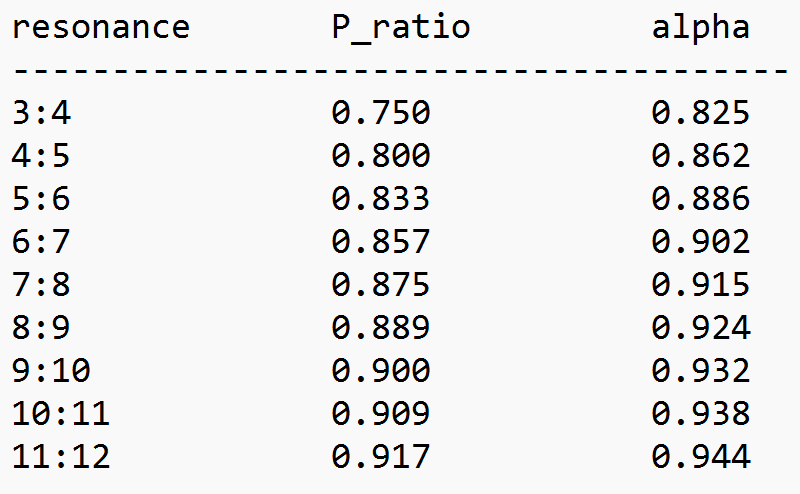
</div>